<a href="https://colab.research.google.com/github/longer147/NIXTLA-Tutorials/blob/main/Multivariate_Forecasting_with_TSMixer_zll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install neuralforecast datasetsforecast


In [2]:
import pandas as pd

from datasetsforecast.long_horizon import LongHorizon

In [3]:
Y_df = pd.read_csv(r'./data_gz_multivariate.csv').drop(columns=['Unnamed: 0'])
Y_df

,ds,unique_id,y,NMS,CBCI - TVWI,DXY,SSEC,SBYR
0,2008-01-02,1y,3.6894,680.0,118.10,76.03,5272.81,0.55
1,2008-01-02,3y,4.0098,680.0,118.10,76.03,5272.81,0.55
2,2008-01-02,5y,4.2144,680.0,118.10,76.03,5272.81,0.55
3,2008-01-02,7y,4.3307,680.0,118.10,76.03,5272.81,0.55
4,2008-01-02,10y,4.4363,680.0,118.10,76.03,5272.81,0.55
...,...,...,...,...,...,...,...,...
24997,2025-03-06,3y,1.5468,-1105.0,252.65,104.21,3381.10,4.38
24998,2025-03-06,5y,1.5980,-1105.0,252.65,104.21,3381.10,4.38
24999,2025-03-06,7y,1.7117,-1105.0,252.65,104.21,3381.10,4.38
25000,2025-03-06,10y,1.7455,-1105.0,252.65,104.21,3381.10,4.38


In [4]:
# # Change this to your own data to try the model
# Y_df, X_df, _ = LongHorizon.load(directory='./', group='ETTm2')
# Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# # X_df contains the exogenous features, which we add to Y_df
# X_df['ds'] = pd.to_datetime(X_df['ds'])
# Y_df = Y_df.merge(X_df, on=['unique_id', 'ds'], how='left')

# We make validation and test splits
n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

In [5]:
val_size

833

In [6]:
test_size

833

In [7]:
Y_df

,ds,unique_id,y,NMS,CBCI - TVWI,DXY,SSEC,SBYR
0,2008-01-02,1y,3.6894,680.0,118.10,76.03,5272.81,0.55
1,2008-01-02,3y,4.0098,680.0,118.10,76.03,5272.81,0.55
2,2008-01-02,5y,4.2144,680.0,118.10,76.03,5272.81,0.55
3,2008-01-02,7y,4.3307,680.0,118.10,76.03,5272.81,0.55
4,2008-01-02,10y,4.4363,680.0,118.10,76.03,5272.81,0.55
...,...,...,...,...,...,...,...,...
24997,2025-03-06,3y,1.5468,-1105.0,252.65,104.21,3381.10,4.38
24998,2025-03-06,5y,1.5980,-1105.0,252.65,104.21,3381.10,4.38
24999,2025-03-06,7y,1.7117,-1105.0,252.65,104.21,3381.10,4.38
25000,2025-03-06,10y,1.7455,-1105.0,252.65,104.21,3381.10,4.38


In [8]:
Y_df.dtypes

,0
ds,object
unique_id,object
y,float64
NMS,float64
CBCI - TVWI,float64
DXY,float64
SSEC,float64
SBYR,float64


In [9]:
# 使用 .loc 进行赋值操作
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [10]:
import logging

import torch
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TSMixer, TSMixerx, NHITS, MLPMultivariate, LSTM
from neuralforecast.losses.pytorch import MAE

In [11]:
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
torch.set_float32_matmul_precision('high')

In [12]:
num_time_series = Y_df['unique_id'].nunique()  # Replace 'unique_id' with the actual column name if different
print(f"Number of unique time series: {num_time_series}")

Number of unique time series: 6


In [13]:
horizon = 5
input_size = 60
models = [
          TSMixer(h=horizon,
                input_size=input_size,
                n_series=num_time_series,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=5,
                scaler_type='identity',
                valid_loss=MAE(),
                random_seed=12345678,
                ),
          TSMixerx(h=horizon,
                input_size=input_size,
                n_series=num_time_series,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=5,
                scaler_type='identity',
                dropout=0.7,
                valid_loss=MAE(),
                random_seed=12345678,
                futr_exog_list=['NMS', 'CBCI - TVWI', 'DXY', 'SSEC', 'SBYR'],
                ),
          MLPMultivariate(h=horizon,
                input_size=input_size,
                n_series=num_time_series,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=5,
                scaler_type='standard',
                hidden_size=256,
                valid_loss=MAE(),
                random_seed=12345678,
                ),
           NHITS(h=horizon,
                input_size=horizon,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=5,
                scaler_type='robust',
                valid_loss=MAE(),
                random_seed=12345678,
                ),
           LSTM(input_size=3*horizon,
                h=horizon,
                max_steps=800,
                scaler_type='standard',
                encoder_hidden_size=64,
                decoder_hidden_size=64,
                valid_loss=MAE(),
                early_stop_patience_steps=5,
                random_seed=12345678,
             ),

         ]

INFO:lightning_fabric.utilities.seed:Seed set to 12345678
INFO:lightning_fabric.utilities.seed:Seed set to 12345678
INFO:lightning_fabric.utilities.seed:Seed set to 12345678
INFO:lightning_fabric.utilities.seed:Seed set to 12345678
INFO:lightning_fabric.utilities.seed:Seed set to 12345678


In [14]:
nf = NeuralForecast(
    models=models,
    freq='D',
)

Y_hat_df = nf.cross_validation(
    df=Y_df,
    val_size=val_size,
    test_size=test_size,
    n_windows=None,
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [15]:
from utilsforecast.plotting import plot_series

In [16]:
Y_hat_df

,unique_id,ds,cutoff,TSMixer,TSMixerx,MLPMultivariate,NHITS,LSTM,y
0,10y,2021-09-23,2021-09-22,2.872328,2.909882,2.863156,2.862594,2.889912,2.8565
1,10y,2021-09-24,2021-09-22,2.869683,2.913655,2.853222,2.861898,2.885049,2.8719
2,10y,2021-09-27,2021-09-22,2.877371,2.906391,2.852593,2.860113,2.880972,2.8825
3,10y,2021-09-28,2021-09-22,2.872760,2.909397,2.846337,2.859920,2.880909,2.8769
4,10y,2021-09-29,2021-09-22,2.877088,2.907858,2.860515,2.858291,2.886744,2.8646
...,...,...,...,...,...,...,...,...,...
24865,7y,2025-02-28,2025-02-27,1.733296,1.647171,1.752542,1.747051,1.753526,1.6918
24866,7y,2025-03-03,2025-02-27,1.729380,1.644425,1.743705,1.747091,1.743690,1.6572
24867,7y,2025-03-04,2025-02-27,1.731322,1.638009,1.739515,1.749423,1.750056,1.6745
24868,7y,2025-03-05,2025-02-27,1.732237,1.646267,1.752016,1.746713,1.768628,1.6618


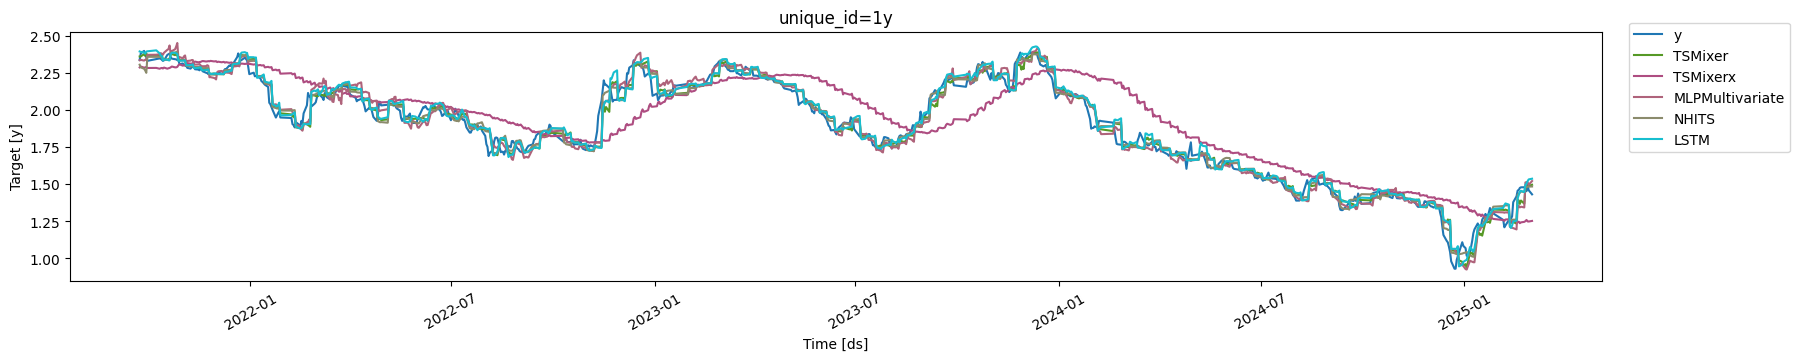

In [17]:
cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
Y_plot = Y_hat_df[Y_hat_df['cutoff'].isin(cutoffs)].drop(columns='cutoff')
plot_series(forecasts_df=Y_plot, ids=['1y'])

In [18]:
Y_hat_df['unique_id'].unique()

array(['10y', '1y', '20y', '3y', '5y', '7y'], dtype=object)

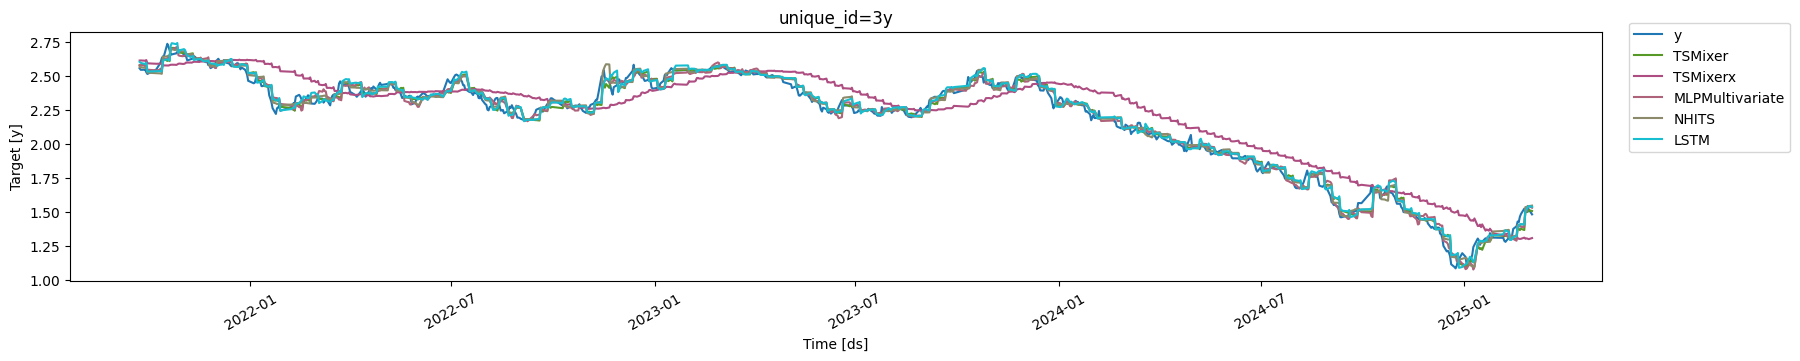

In [19]:
plot_series(forecasts_df=Y_plot, ids=['3y'])

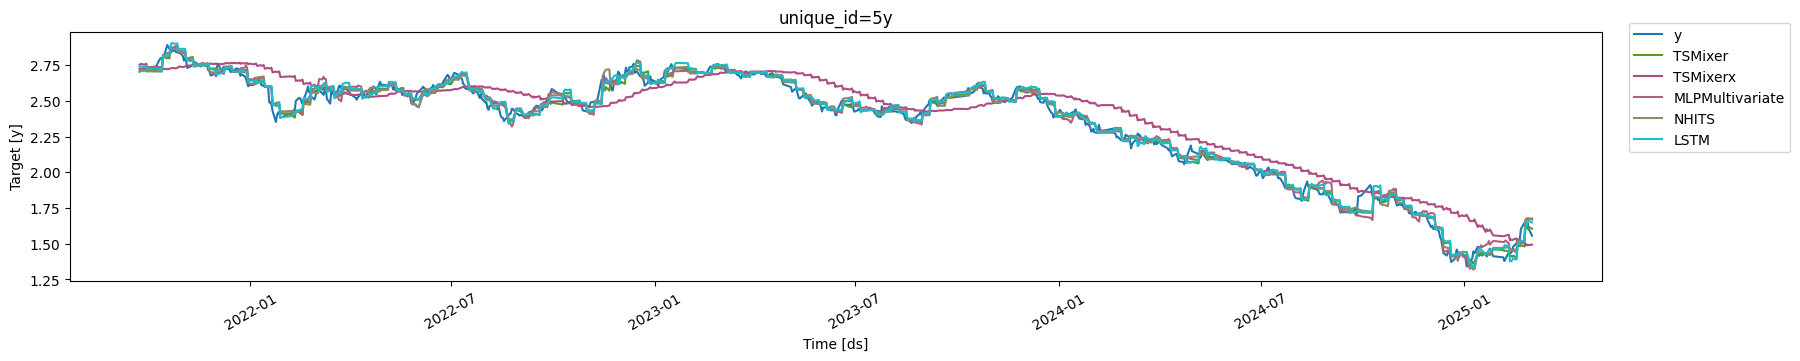

In [20]:
plot_series(forecasts_df=Y_plot, ids=['5y'])

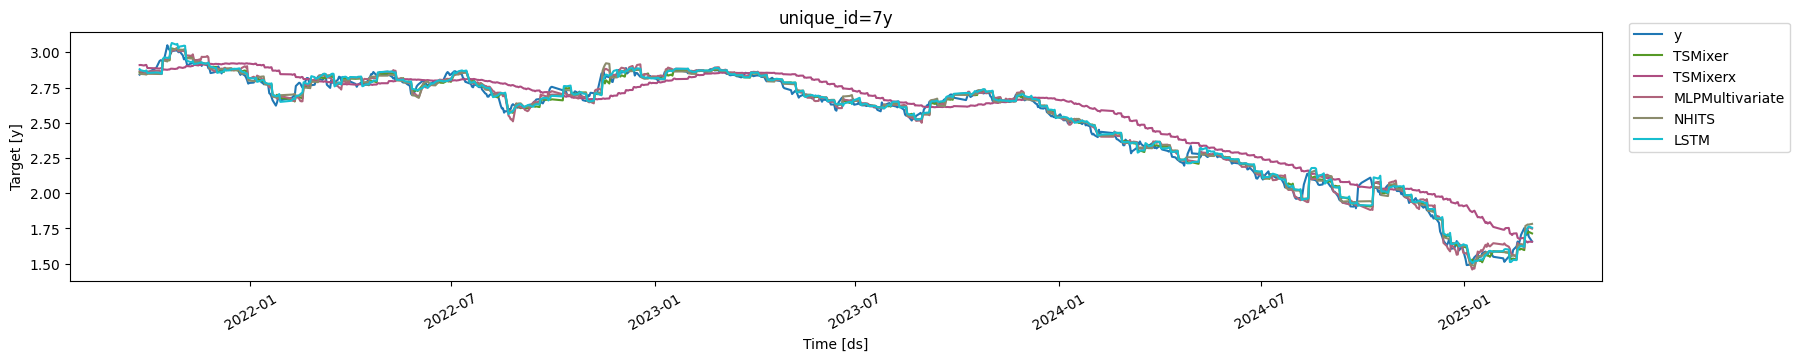

In [21]:
plot_series(forecasts_df=Y_plot, ids=['7y'])

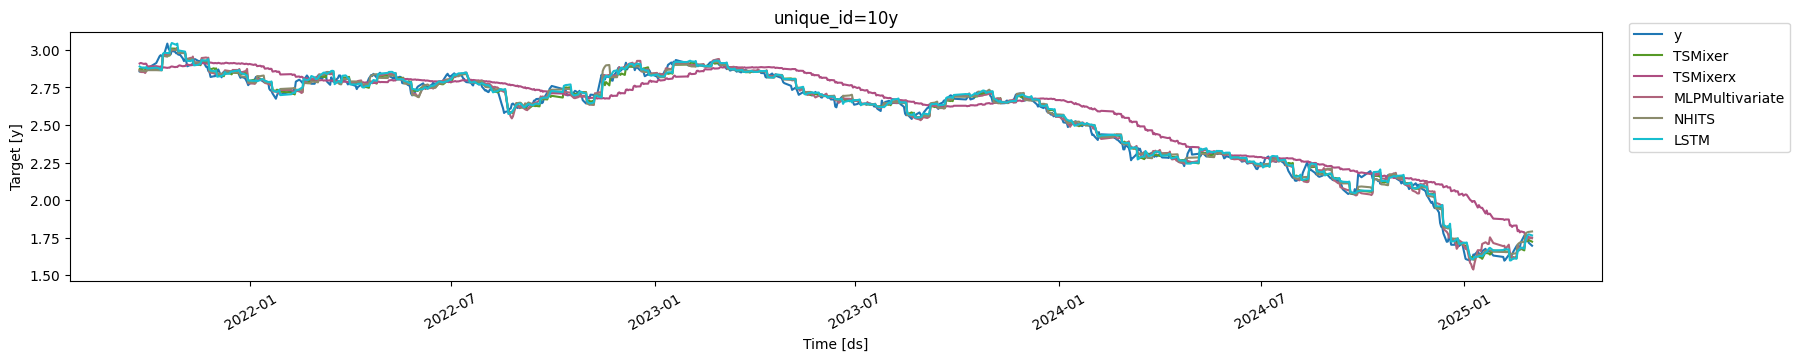

In [22]:
plot_series(forecasts_df=Y_plot, ids=['10y'])

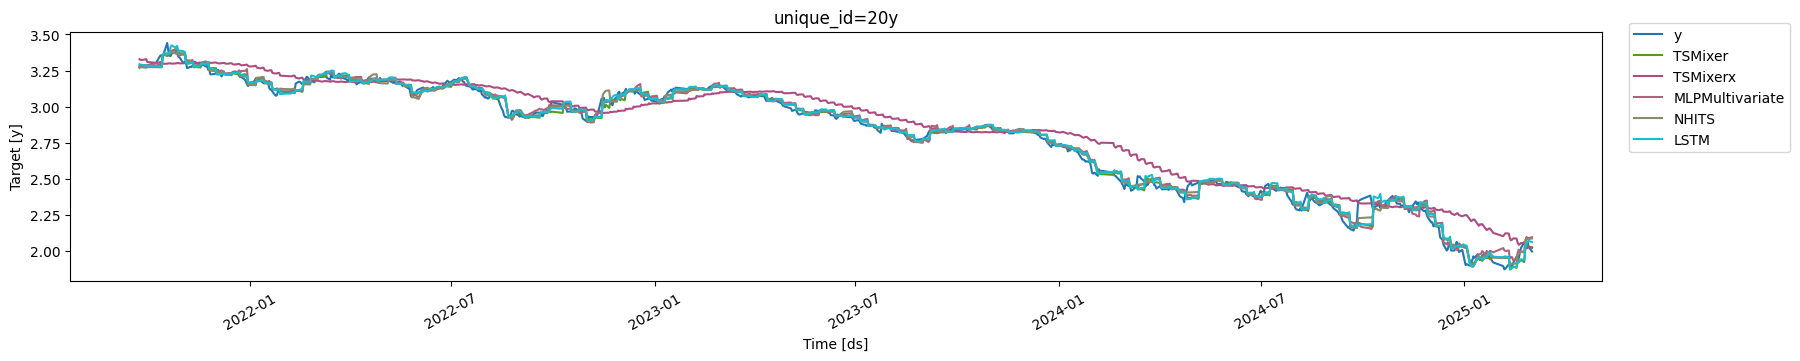

In [23]:
plot_series(forecasts_df=Y_plot, ids=['20y'])

In [24]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, mse,rmse,mape,smape,mase

In [25]:
rusult_0 = evaluate(Y_hat_df.drop(columns='cutoff'), metrics=[mae,mse,rmse,mape,smape], agg_fn='mean')
rusult_0['unique_id'] = 'all'
rusult_0

,metric,TSMixer,TSMixerx,MLPMultivariate,NHITS,LSTM,unique_id
0,mae,0.030665,0.095641,0.032727,0.028933,0.032860,all
1,mse,0.001878,0.015352,0.002077,0.001677,0.002035,all
2,rmse,0.042555,0.122072,0.044710,0.040336,0.044347,all
3,mape,0.014237,0.045597,0.015257,0.013368,0.015247,all
4,smape,0.007118,0.022076,0.007628,0.006673,0.007593,all


In [26]:
rusult_1y = evaluate(Y_hat_df.drop(columns='cutoff')[Y_hat_df['unique_id'] == '1y'], metrics=[mae,mse,rmse,mape,smape], agg_fn='mean')
rusult_1y['unique_id'] = '1y'
rusult_1y

,metric,TSMixer,TSMixerx,MLPMultivariate,NHITS,LSTM,unique_id
0,mae,0.041127,0.128821,0.046804,0.037391,0.043554,1y
1,mse,0.003436,0.026843,0.003953,0.002880,0.003644,1y
2,rmse,0.058621,0.163840,0.062872,0.053665,0.060362,1y
3,mape,0.023050,0.071555,0.025944,0.020894,0.024286,1y
4,smape,0.011535,0.034701,0.013013,0.010434,0.012076,1y


In [27]:
rusult_3y = evaluate(Y_hat_df.drop(columns='cutoff')[Y_hat_df['unique_id'] == '3y'], metrics=[mae,mse,rmse,mape,smape], agg_fn='mean')
rusult_3y['unique_id'] = '3y'
rusult_3y

,metric,TSMixer,TSMixerx,MLPMultivariate,NHITS,LSTM,unique_id
0,mae,0.033515,0.107514,0.033540,0.031512,0.035664,3y
1,mse,0.002094,0.017269,0.002077,0.001861,0.002245,3y
2,rmse,0.045763,0.131412,0.045576,0.043144,0.047381,3y
3,mape,0.016628,0.055047,0.016585,0.015532,0.017613,3y
4,smape,0.008311,0.026552,0.008296,0.007751,0.008765,3y


In [28]:
rusult_5y = evaluate(Y_hat_df.drop(columns='cutoff')[Y_hat_df['unique_id'] == '5y'], metrics=[mae,mse,rmse,mape,smape], agg_fn='mean')
rusult_5y['unique_id'] = '5y'
rusult_5y

,metric,TSMixer,TSMixerx,MLPMultivariate,NHITS,LSTM,unique_id
0,mae,0.031890,0.096338,0.034077,0.030980,0.034668,5y
1,mse,0.001822,0.014103,0.002067,0.001751,0.002037,5y
2,rmse,0.042688,0.118755,0.045469,0.041842,0.045131,5y
3,mape,0.014304,0.045108,0.015547,0.013913,0.015634,5y
4,smape,0.007149,0.021867,0.007753,0.006945,0.007791,5y


In [29]:
rusult_7y = evaluate(Y_hat_df.drop(columns='cutoff')[Y_hat_df['unique_id'] == '7y'], metrics=[mae,mse,rmse,mape,smape], agg_fn='mean')
rusult_7y['unique_id'] = '7y'
rusult_7y

,metric,TSMixer,TSMixerx,MLPMultivariate,NHITS,LSTM,unique_id
0,mae,0.027534,0.086127,0.029200,0.026190,0.029905,7y
1,mse,0.001480,0.012307,0.001651,0.001345,0.001640,7y
2,rmse,0.038466,0.110937,0.040636,0.036669,0.040494,7y
3,mape,0.011678,0.038100,0.012410,0.011055,0.012716,7y
4,smape,0.005840,0.018422,0.006205,0.005520,0.006341,7y


In [30]:
rusult_10y = evaluate(Y_hat_df.drop(columns='cutoff')[Y_hat_df['unique_id'] == '10y'], metrics=[mae,mse,rmse,mape,smape], agg_fn='mean')
rusult_10y['unique_id'] = '10y'
rusult_10y

,metric,TSMixer,TSMixerx,MLPMultivariate,NHITS,LSTM,unique_id
0,mae,0.025237,0.080493,0.026643,0.024189,0.026926,10y
1,mse,0.001206,0.011978,0.001360,0.001116,0.001312,10y
2,rmse,0.034734,0.109443,0.036878,0.033412,0.036222,10y
3,mape,0.010374,0.034976,0.011087,0.009941,0.011138,10y
4,smape,0.005178,0.016884,0.005530,0.004958,0.005546,10y


In [31]:
rusult_20y = evaluate(Y_hat_df.drop(columns='cutoff')[Y_hat_df['unique_id'] == '20y'], metrics=[mae,mse,rmse,mape,smape], agg_fn='mean')
rusult_20y['unique_id'] = '20y'
rusult_20y

,metric,TSMixer,TSMixerx,MLPMultivariate,NHITS,LSTM,unique_id
0,mae,0.024688,0.074550,0.026102,0.023333,0.026443,20y
1,mse,0.001229,0.009613,0.001356,0.001108,0.001332,20y
2,rmse,0.035056,0.098045,0.036825,0.033283,0.036495,20y
3,mape,0.009389,0.028796,0.009968,0.008870,0.010096,20y
4,smape,0.004693,0.014032,0.004969,0.004429,0.005036,20y


In [32]:
rusult_all = pd.concat([rusult_0,rusult_1y,rusult_3y,rusult_7y,rusult_10y,rusult_20y], axis=0)
rusult_all

,metric,TSMixer,TSMixerx,MLPMultivariate,NHITS,LSTM,unique_id
0,mae,0.030665,0.095641,0.032727,0.028933,0.032860,all
1,mse,0.001878,0.015352,0.002077,0.001677,0.002035,all
2,rmse,0.042555,0.122072,0.044710,0.040336,0.044347,all
3,mape,0.014237,0.045597,0.015257,0.013368,0.015247,all
4,smape,0.007118,0.022076,0.007628,0.006673,0.007593,all
0,mae,0.041127,0.128821,0.046804,0.037391,0.043554,1y
1,mse,0.003436,0.026843,0.003953,0.002880,0.003644,1y
2,rmse,0.058621,0.163840,0.062872,0.053665,0.060362,1y
3,mape,0.023050,0.071555,0.025944,0.020894,0.024286,1y
4,smape,0.011535,0.034701,0.013013,0.010434,0.012076,1y


<ipython-input-33-53a7702b4438>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(rusult_all, x='TSMixerx', y='metric', inner='stick', palette='Dark2')


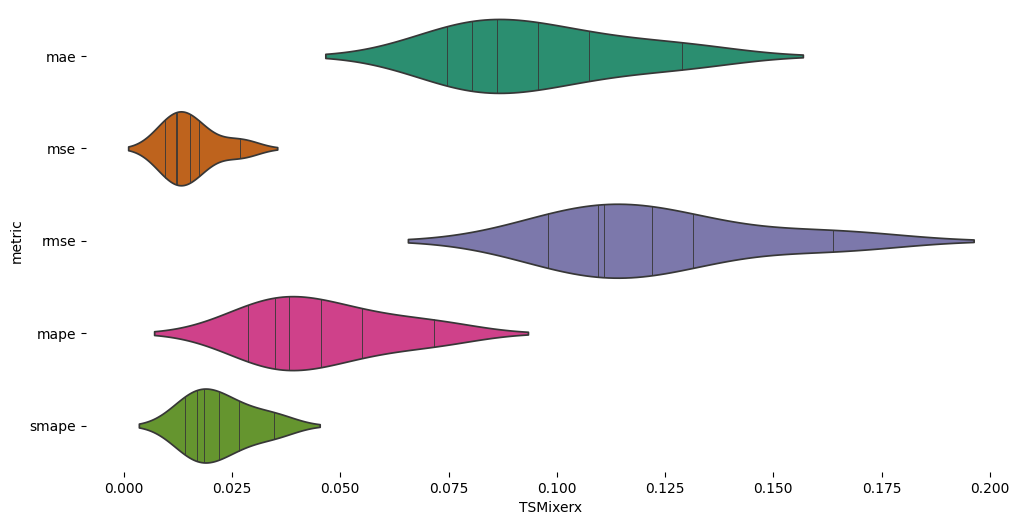

In [33]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(rusult_all['metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(rusult_all, x='TSMixerx', y='metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<Axes: xlabel='smape', ylabel='model'>

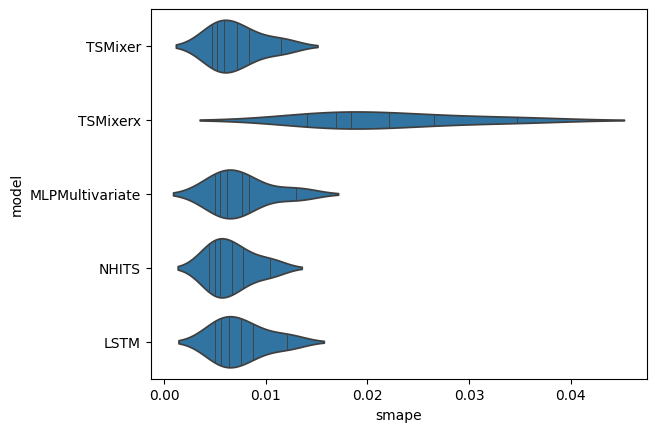

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
evaluation_df_long = pd.melt(rusult_all, id_vars=['unique_id', 'metric'], var_name='model', value_name='smape')
sns.violinplot(evaluation_df_long.query('metric=="smape"'), x='smape', y='model', inner='stick')

<ipython-input-35-caf3a55042e0>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


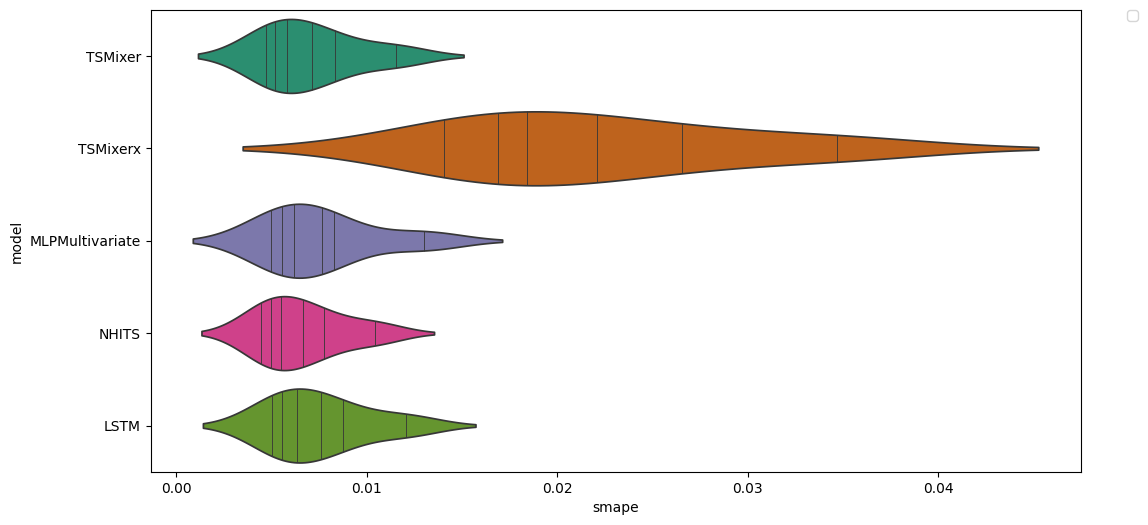

In [35]:
# prompt: 上述生成的小提琴图用不同的颜色区分模型，并加上坐标轴和网格

figsize = (12, 1.2 * len(rusult_all['metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data=evaluation_df_long.query('metric=="smape"'), x='smape', y='model', hue='model', inner='stick', palette='Dark2')
# sns.despine(top=True, right=True, bottom=True, left=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [36]:
ssstop

NameError: name 'ssstop' is not defined

In [ ]:
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.auto import AutoTSMixer, AutoTSMixerx

In [ ]:
horizon = 5 # 24hrs = 4 * 15 min.

tsmixer_config = {
       "input_size": input_size,                                                 # Size of input window
       "max_steps": tune.choice([500, 1000, 2000]),                              # Number of training iterations
       "val_check_steps": 100,                                                   # Compute validation every x steps
       "early_stop_patience_steps": 5,                                           # Early stopping steps
       "learning_rate": tune.loguniform(1e-4, 1e-2),                             # Initial Learning rate
       "n_block": tune.choice([1, 2, 4, 6, 8]),                                  # Number of mixing layers
       "dropout": tune.uniform(0.0, 0.99),                                       # Dropout
       "ff_dim": tune.choice([32, 64, 128]),                                     # Dimension of the feature linear layer
       "scaler_type": 'identity',
    }

tsmixerx_config = tsmixer_config.copy()
tsmixerx_config['futr_exog_list'] = ['NMS', 'CBCI - TVWI', 'DXY', 'SSEC', 'SBYR']

In [ ]:
model = AutoTSMixer(h=horizon,
                    n_series=num_time_series,
                    loss=MAE(),
                    config=tsmixer_config,
                    num_samples=10,
                    search_alg=HyperOptSearch(),
                    backend='ray',
                    valid_loss=MAE())

modelx = AutoTSMixerx(h=horizon,
                    n_series=num_time_series,
                    loss=MAE(),
                    config=tsmixerx_config,
                    num_samples=10,
                    search_alg=HyperOptSearch(),
                    backend='ray',
                    valid_loss=MAE())

In [ ]:
nf = NeuralForecast(models=[model, modelx], freq='W')
Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size,
                               test_size=test_size, n_windows=None)

In [ ]:
nf.models[0].results.get_best_result().config

In [ ]:
nf.models[1].results.get_best_result().config

In [ ]:
evaluate(Y_hat_df.drop(columns='cutoff'), metrics=[mae,mse,rmse,mape,smape], agg_fn='mean')